In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
from scipy.stats import pearsonr
import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels
import pandas as pd
from pandas_datareader import data
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)

In [48]:
data_inicio = '2000-01-01'
data_fim = '2021-09-24'

In [49]:
df = data.DataReader('petr4.sa', 'yahoo', data_inicio, data_fim)
df['data_pregao'] = df.index
df['mm5D'] = df['Adj Close'].rolling(5).mean()
df['mm21D'] = df['Adj Close'].rolling(21).mean()
df

,High,Low,Open,Close,Volume,Adj Close,data_pregao,mm5D,mm21D
Date,,,,,,,,,
2000-01-03,5.875000,5.875000,5.875000,5.875000,3.538944e+10,3.598473,2000-01-03,NaN,NaN
2000-01-04,5.550000,5.550000,5.550000,5.550000,2.886144e+10,3.399408,2000-01-04,NaN,NaN
2000-01-05,5.494000,5.494000,5.494000,5.494000,4.303360e+10,3.365109,2000-01-05,NaN,NaN
2000-01-06,5.475000,5.475000,5.475000,5.475000,3.405568e+10,3.353472,2000-01-06,NaN,NaN
2000-01-07,5.500000,5.500000,5.500000,5.500000,2.091264e+10,3.368784,2000-01-07,3.417049,NaN
...,...,...,...,...,...,...,...,...,...
2021-09-20,24.650000,23.790001,24.080000,24.650000,8.026060e+07,24.650000,2021-09-20,25.578000,26.512381
2021-09-21,25.290001,24.530001,25.080000,25.209999,6.457020e+07,25.209999,2021-09-21,25.444000,26.446190
2021-09-22,26.219999,25.520000,25.530001,25.850000,7.023180e+07,25.850000,2021-09-22,25.348000,26.390476


In [50]:
selic = pd.read_json('https://api.bcb.gov.br/dados/serie/bcdata.sgs.11/dados?formato=json&dataInicial=04/01/2000&dataFinal=24/09/2021')
selic['data'] = selic['data'].str.replace('/', '-')
selic['data'] = pd.to_datetime(selic['data'], format='%d-%m-%Y')
selic['data'] = pd.to_datetime(selic["data"].dt.strftime('%Y-%m-%d'))
selic = selic.rename(columns={'valor':'SELIC', 'data': 'data_pregao'})
selic['mm5D_selic'] = selic['SELIC'].rolling(5).mean()
selic['mm21D_selic'] = selic['SELIC'].rolling(21).mean()
selic

,data_pregao,SELIC,mm5D_selic,mm21D_selic
0,2000-01-04,0.069186,NaN,NaN
1,2000-01-05,0.069220,NaN,NaN
2,2000-01-06,0.069286,NaN,NaN
3,2000-01-07,0.069286,NaN,NaN
4,2000-01-10,0.069120,0.069220,NaN
...,...,...,...,...
5452,2021-09-17,0.019930,0.019930,0.019930
5453,2021-09-20,0.019930,0.019930,0.019930
5454,2021-09-21,0.019930,0.019930,0.019930
5455,2021-09-22,0.019930,0.019930,0.019930


In [51]:
selic_acao = (df.merge(selic, on='data_pregao', how='left', suffixes=('', '_y'))
     .rename(lambda x: x.replace('_y', ''), axis=1))
selic_acao.tail(10)

,High,Low,Open,Close,Volume,Adj Close,data_pregao,mm5D,mm21D,SELIC,mm5D_selic,mm21D_selic
5449,26.389999,25.639999,25.799999,26.230000,63317900.0,26.230000,2021-09-13,25.700,26.860013,0.019930,0.019930,0.019930
5450,26.250000,25.719999,25.950001,25.879999,65497300.0,25.879999,2021-09-14,25.584,26.773338,0.019930,0.019930,0.019930
5451,26.459999,25.870001,26.000000,26.330000,67274100.0,26.330000,2021-09-15,25.856,26.740000,0.019930,0.019930,0.019930
5452,26.240000,25.510000,26.080000,26.100000,65567700.0,26.100000,2021-09-16,25.976,26.695714,0.019930,0.019930,0.019930
5453,26.020000,24.770000,25.969999,24.930000,131694100.0,24.930000,2021-09-17,25.894,26.607143,0.019930,0.019930,0.019930
5454,24.650000,23.790001,24.080000,24.650000,80260600.0,24.650000,2021-09-20,25.578,26.512381,0.019930,0.019930,0.019930
5455,25.290001,24.530001,25.080000,25.209999,64570200.0,25.209999,2021-09-21,25.444,26.446190,0.019930,0.019930,0.019930
5456,26.219999,25.520000,25.530001,25.850000,70231800.0,25.850000,2021-09-22,25.348,26.390476,0.019930,0.019930,0.019930
5457,26.950001,25.910000,25.950001,26.840000,84480600.0,26.840000,2021-09-23,25.496,26.355238,0.023687,0.020681,0.020109
5458,27.059999,26.469999,26.549999,26.860001,30651400.0,26.860001,2021-09-24,25.882,26.313809,NaN,NaN,NaN


In [52]:
#usd = data.DataReader('USDBRL=X', 'yahoo', data_inicio, data_fim)
#usd['data_pregao'] = usd.index
#usd = usd.reset_index(drop=True)
#usd = usd.rename(columns=({'High': 'USD_High', 'Low':'USD_Low', 'Open':'USD_Open', 'Close':'USD_Close', 'Volume': 'USD_Volume', 'Adj Close': 'Adj Close_USD'}))
#usd = usd.drop(columns=['USD_Volume'])

In [53]:
#selic_acao_usd = (usd.merge(selic_acao, on='data_pregao', how='left', suffixes=('', '_y'))
     #.rename(lambda x: x.replace('_y', ''), axis=1))
#selic_acao_usd.index = selic_acao_usd.data_pregao
#selic_acao_usd.tail(50)

In [54]:
df_analyze = selic_acao

In [55]:
df_analyze.index = selic_acao['data_pregao']

In [56]:
df_analyze = df_analyze.drop(columns=['data_pregao'])

In [57]:
df_analyze.dropna(inplace=True)

In [58]:
df_analyze.tail(10)

,High,Low,Open,Close,Volume,Adj Close,mm5D,mm21D,SELIC,mm5D_selic,mm21D_selic
data_pregao,,,,,,,,,,,
2021-09-10,26.139999,25.330000,26.020000,25.340000,78379900.0,25.340000,25.720,26.918786,0.019930,0.019930,0.019930
2021-09-13,26.389999,25.639999,25.799999,26.230000,63317900.0,26.230000,25.700,26.860013,0.019930,0.019930,0.019930
2021-09-14,26.250000,25.719999,25.950001,25.879999,65497300.0,25.879999,25.584,26.773338,0.019930,0.019930,0.019930
2021-09-15,26.459999,25.870001,26.000000,26.330000,67274100.0,26.330000,25.856,26.740000,0.019930,0.019930,0.019930
2021-09-16,26.240000,25.510000,26.080000,26.100000,65567700.0,26.100000,25.976,26.695714,0.019930,0.019930,0.019930
2021-09-17,26.020000,24.770000,25.969999,24.930000,131694100.0,24.930000,25.894,26.607143,0.019930,0.019930,0.019930
2021-09-20,24.650000,23.790001,24.080000,24.650000,80260600.0,24.650000,25.578,26.512381,0.019930,0.019930,0.019930
2021-09-21,25.290001,24.530001,25.080000,25.209999,64570200.0,25.209999,25.444,26.446190,0.019930,0.019930,0.019930
2021-09-22,26.219999,25.520000,25.530001,25.850000,70231800.0,25.850000,25.348,26.390476,0.019930,0.019930,0.019930


In [59]:
#scaler = StandardScaler()
#df_analyze_scaled = scaler.fit_transform(df_analyze)

In [60]:
#df_analyze_scaled = pd.DataFrame(df_analyze_scaled)
#df_analyze_scaled.columns = df_analyze.columns
#df_analyze_scaled.index = df_analyze.index

In [61]:
correlation = df_analyze.corr()

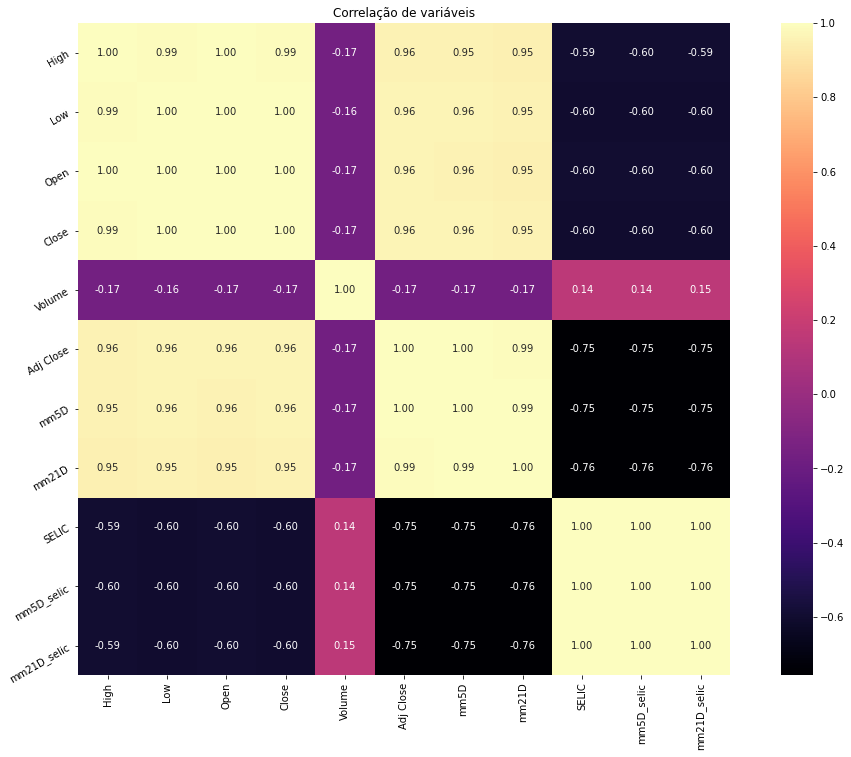

In [62]:
plt.title('Correlação de variáveis')
heatcorr = sns.heatmap(correlation, square=True, annot=True, fmt='.2f', linecolor='white', cmap='magma')
heatcorr.set_xticklabels(heatcorr.get_xticklabels(), rotation=90)
heatcorr.set_yticklabels(heatcorr.get_yticklabels(), rotation=30)           
plt.show()

In [63]:
df_train = df_analyze.copy()

In [64]:
df_train['Adj Close'] = df_train['Adj Close'].shift(-1)

In [65]:
n_rows = len(df_train)
rows_train = round(0.75 * n_rows)
rows_test = n_rows - rows_train
rows_validate =  n_rows -1

info = (
    f"linhas treino= 0:{rows_train}"
    f" linhas teste= {rows_train}:{rows_train + rows_test}"
    f" linhas validação= {rows_validate}:{n_rows}"
)

info

'linhas treino= 0:4031 linhas teste= 4031:5375 linhas validação= 5374:5375'

In [66]:
df_train = pd.DataFrame(df_train)
df_train.columns = df_analyze.columns

In [67]:
features = df_train.drop(['Close', 'Adj Close', ], axis = 1)
labels = df_train['Close']

In [68]:
features_list = features.columns

In [69]:
from sklearn.feature_selection import SelectKBest

k_best_features = SelectKBest(k='all')
k_best_features.fit_transform(features, labels)
k_best_features_scores = k_best_features.scores_
raw_pairs = zip(features_list[1:], k_best_features_scores)
ordered_pairs = list(reversed(sorted(raw_pairs, key=lambda x: x[1])))

k_best_features_final = dict(ordered_pairs[:15])
best_features = k_best_features_final.keys()
print ("Melhores features:")
print (k_best_features_final)

Melhores features:
{'Open': 1621.6652202763833, 'Volume': 112.52998147029002, 'Low': 61.49165333033791, 'mm21D': 34.28794726271962, 'SELIC': 26.42816139164017, 'mm5D_selic': 3.630922249055261, 'mm21D_selic': 3.613251479279628, 'mm5D': 2.4704512465689605}


In [83]:
features = df_train.loc[:,['Low', 'Volume', 'mm21D']]

In [84]:
X_train = features[:rows_train]
X_test = features[rows_train:rows_train + rows_test -1]

y_train = labels[:rows_train]
y_test = labels[rows_train:rows_train + rows_test -1]

print( len(X_train), len(y_train))

print( len(X_test), len(y_test))

4031 4031
1343 1343


In [85]:
scaler = MinMaxScaler()

X_train_scale = scaler.fit_transform(X_train)  # Normalizando os dados de entrada(treinamento)

X_test_scale  = scaler.transform(X_test)       # Normalizando os dados de entrada(teste)

features_scale = scaler.transform(features)
print('Features:', features_scale.shape) 
print(features_scale)

Features: (5375, 3)
[[0.02257997 0.32179148 0.01012163]
 [0.02467071 0.19400752 0.00988273]
 [0.02780681 0.35276308 0.00984069]
 ...
 [0.42671964 0.00087774 0.76946872]
 [0.44741794 0.0009547  0.76764336]
 [0.45557181 0.00114839 0.76648887]]


In [86]:
lr = linear_model.LinearRegression(n_jobs=10000)
lr.fit(X_train_scale, y_train)
pred= lr.predict(X_test_scale)
cd =r2_score(y_test, pred)

f'Coeficiente de determinação:{cd * 100:.2f}'

'Coeficiente de determinação:99.75'

In [87]:
rn = MLPRegressor(max_iter=10000)

rn.fit(X_train_scale, y_train)
pred= rn.predict(X_test_scale)

cd = rn.score(X_test_scale, y_test)


f'Coeficiente de determinação:{cd * 100:.2f}'

'Coeficiente de determinação:99.74'

In [88]:
previsao = features_scale[rows_test:n_rows]

data_pregao_full = df_analyze.index

data_pregao = data_pregao_full[rows_test:n_rows]

result_full = df['Close']
result = result_full[rows_test:n_rows]

pred = rn.predict(previsao)

In [89]:
data_pregao

DatetimeIndex(['2005-06-09', '2005-06-10', '2005-06-13', '2005-06-14',
               '2005-06-15', '2005-06-16', '2005-06-17', '2005-06-20',
               '2005-06-21', '2005-06-22',
               ...
               '2021-09-10', '2021-09-13', '2021-09-14', '2021-09-15',
               '2021-09-16', '2021-09-17', '2021-09-20', '2021-09-21',
               '2021-09-22', '2021-09-23'],
              dtype='datetime64[ns]', name='data_pregao', length=4031, freq=None)

In [90]:
df_pred = pd.DataFrame({'data_pregao':data_pregao, 'real': result, 'previsao': pred})

df_pred['real'] = df_pred['real'].shift(+1)

df_pred.set_index(data_pregao, inplace= True)

df_pred

,data_pregao,real,previsao
data_pregao,,,
2005-06-09,2005-06-09,NaN,12.529385
2005-06-10,2005-06-10,14.187500,12.816552
2005-06-13,2005-06-13,14.412500,12.793390
2005-06-14,2005-06-14,14.468750,12.785525
2005-06-15,2005-06-15,14.300000,12.857467
...,...,...,...
2021-09-17,2021-09-17,26.150000,25.342203
2021-09-20,2021-09-20,25.930000,24.362643
2021-09-21,2021-09-21,25.950001,25.099191


In [92]:
for index, row in df_pred.iterrows():
    df_pred.loc[index,'diferenca'] = (df_pred.loc[index,'real'] - df_pred.loc[index,'previsao']);
df_pred.tail(40)

,data_pregao,real,previsao,diferenca
data_pregao,,,,
2021-07-29,2021-07-29,23.830000,28.053026,-4.223026
2021-07-30,2021-07-30,23.830000,27.382132,-3.552132
2021-08-02,2021-08-02,24.100000,26.920592,-2.820591
2021-08-03,2021-08-03,23.889999,26.339692,-2.449693
2021-08-04,2021-08-04,24.040001,26.496586,-2.456585
2021-08-05,2021-08-05,24.020000,28.601601,-4.581600
2021-08-06,2021-08-06,24.000000,28.562257,-4.562257
2021-08-09,2021-08-09,23.700001,28.213874,-4.513873
2021-08-10,2021-08-10,23.650000,28.782939,-5.132940


In [93]:
df_pred_2021=df_pred[ (df_pred['data_pregao'] > '2021-01-01')]

In [94]:
#plt.rcParams['figure.figsize'] = (16, 8)
#plt.title("Preço da Ação R$")
#plt.plot(df_pred["real"],label = "Real", color = "blue")
#plt.plot(df_pred["previsao"],label = "Previsto", color = "red")
#plt.xlabel("Data")
#plt.ylabel("Valor fechamento")
#plt.legend()

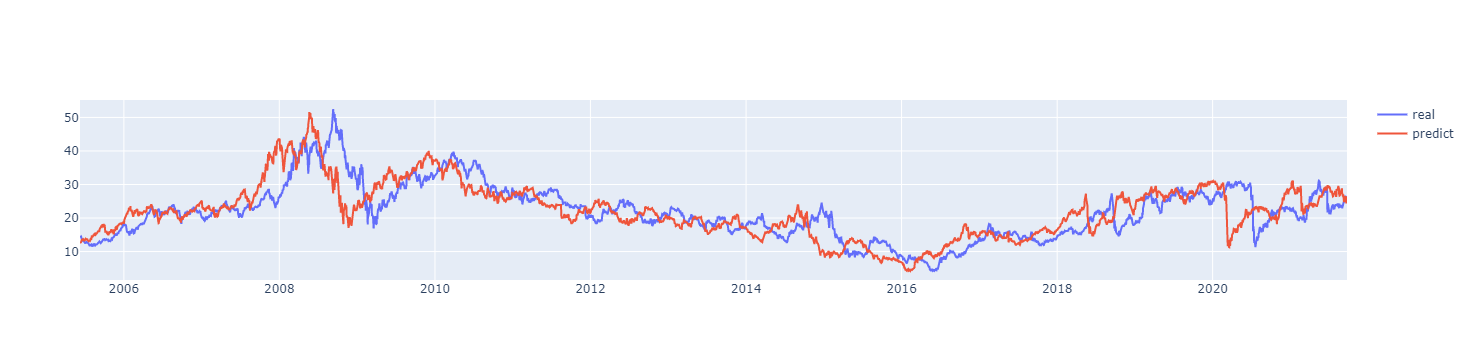

In [95]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(x=df_pred['data_pregao'], y=df_pred['real'], name = 'real')])
fig.add_scatter(x=df_pred['data_pregao'], y=df_pred['previsao'], mode='lines', name='predict')
fig.update_layout(barmode='group', hovermode='x')
fig.show()

In [96]:
#plt.rcParams['figure.figsize'] = (16, 8)
#plt.title("Preço da Ação R$")
#plt.plot(df_pred_2021["real"],label = "Real", color = "blue", marker = 'o')
#plt.plot(df_pred_2021["previsao"],label = "Previsto", color = "red")
#plt.xlabel("Data")
#plt.ylabel("Valor fechamento")
#plt.legend()

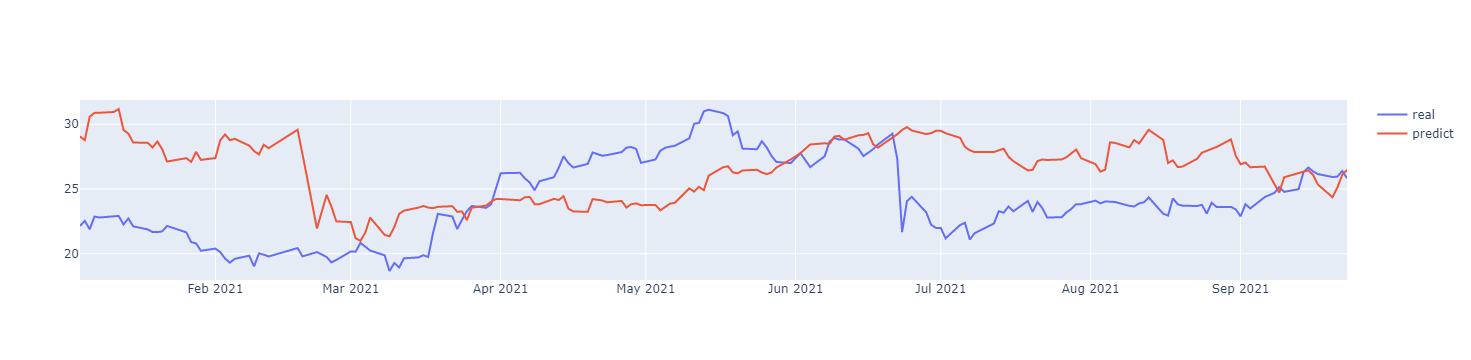

In [97]:
import plotly.graph_objects as go

fig = go.Figure([go.Scatter(x=df_pred_2021['data_pregao'], y=df_pred_2021['real'], name = 'real')])
fig.add_scatter(x=df_pred_2021['data_pregao'], y=df_pred_2021['previsao'], mode='lines', name='predict')
fig.update_layout(barmode='group', hovermode='x')
fig.show()

In [98]:
day1 = features.tail(1)
day1

,Low,Volume,mm21D
data_pregao,,,
2021-09-23,25.91,84480600.0,26.355238


In [99]:
previsao=scaler.transform(day1)


pred_D1 =rn.predict(previsao)

pred_D1

array([26.47344617])

In [100]:
data_pregao_full = df.index
data_pregao=data_pregao_full[-1]

res_full=df['Adj Close']
res=res_full.tail(1)

df_day1=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred_D1})


df_day1.set_index('data_pregao', inplace=True)

print(df_day1)

                  real   previsao
data_pregao                      
2021-09-24   26.860001  26.473446


In [45]:
valor_novo = features.tail(50)

In [46]:
prev_50=scaler.transform(valor_novo)
pred_50=lr.predict(prev_50)

pred_50

array([27.49412447, 27.15252496, 26.43695147, 26.47706921, 27.14428276,
       27.25682767, 27.22314556, 27.26703116, 27.44497821, 27.74167681,
       28.03875902, 27.37873735, 26.91628482, 26.33882278, 26.49506693,
       28.66698839, 28.58078072, 28.23691805, 28.80025675, 28.53392136,
       29.0622285 , 29.58037389, 28.81294325, 27.04159621, 27.23955983,
       26.72287219, 26.76314398, 27.35577588, 27.8203769 , 27.96286896,
       28.05498461, 28.26962136, 28.85726668, 27.61060861, 26.94721171,
       27.07375453, 26.71159934, 26.74939602, 25.40446338, 24.77474928,
       25.93029661, 26.2330921 , 26.30916056, 26.46095834, 26.10323964,
       25.38160442, 24.39293083, 25.11874681, 26.0998283 , 26.53547902])

In [48]:
data_pregao_full =features.index
print()
data_pregao = data_pregao_full[-50:]

res_full=df['Close']
res=res_full.tail(50)

df_n=pd.DataFrame({'data_pregao':data_pregao, 'real':res, 'previsao':pred_50})


df_n.set_index('data_pregao', inplace=True)

df_n

,real,previsao
data_pregao,,
2021-07-15,26.680000,27.495810
2021-07-16,26.240000,27.154238
2021-07-19,26.590000,26.438721
2021-07-20,26.959999,26.478792
2021-07-21,26.900000,27.145850
2021-07-22,26.740000,27.258358
2021-07-23,27.469999,27.224671
2021-07-26,27.150000,27.268552
2021-07-27,27.709999,27.446484
